In [152]:
import os
import csv
import sys
import copy
import time
import logging
import datetime
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [153]:
def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.divide(
        X - tf.reduce_min(X, axis=0),
        tf.reduce_max(X, axis=0) - tf.reduce_min(X, axis=0)
    )

def normalize(X):
    return tf.keras.utils.normalize(X)

def denormalize(x):
    return preprocessing.normalize(x) * stdev(x) + tf.reduce_mean(x)

def stdev(x):
    return tf.square(tf.divide(tf.reduce_sum((x - tf.divide(tf.reduce_sum(x), len(x)))**2), len(x)-1))

def remove_outliers(X, threshold=7):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))

def fill_dataset(dataset):
    data = dataset.copy()
    for col in data.columns:
        data[col].fillna(data[col].mean())
    return data
    


In [154]:
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
batch_size = 120

stocks = pd.read_csv("../data/datasets/all_stocks_5yr.csv")
stocks = pd.DataFrame(stocks)
stocks.drop(["Name", "date"], axis=1, inplace=True)
rnnstocks = stocks.values[0:100, :]
rnnstocks = pd.DataFrame(rnnstocks)
rnnstocks = fill_dataset(rnnstocks)
rnnstocks = pd.DataFrame(rnnstocks)
rnnstocks.columns = stocks.columns

rnnstocks["target"] = rnnstocks["close"]
n_features = len(rnnstocks.values[0])
n_rows = 10
n_ciclics = 10
data = np.array(rnnstocks.values).reshape(n_ciclics, n_rows, n_features)
X_test = data[:, 0:-1, :]
Y_test = data[:, -1, :]

n_rows = 20
n_ciclics = 5
data = np.array(rnnstocks.values).reshape(n_ciclics, n_rows, n_features)
X_train = data[:, 0:-1, :]
Y_train = data[:, -1, :]
rnnstocks.head()


,open,high,low,close,volume,target
0,15.07,15.12,14.63,14.75,8407500.0,14.75
1,14.89,15.01,14.26,14.46,8882000.0,14.46
2,14.45,14.51,14.10,14.27,8126000.0,14.27
3,14.30,14.94,14.25,14.66,10259500.0,14.66
4,14.94,14.96,13.16,13.99,31879900.0,13.99


In [155]:
vif_data = pd.DataFrame()
vif_data["features"] = rnnstocks.columns
vif_data["VIF"] = [variance_inflation_factor(rnnstocks.values, i) for i in range(len(rnnstocks.columns))]
print(vif_data)

  features           VIF
0     open  9.802026e+03
1     high  1.690523e+04
2      low  1.714993e+04
3    close           inf
4   volume  8.106561e+00
5   target           inf


C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [156]:
class DenseLayer(tf.Module):
    def __init__(self, n_neurons, input_dim, activation=tf.identity, dropout=0.0):
        self.n_neurons = n_neurons
        self.input_dim = input_dim
        self.builded = False
        self.activation = activation
        self.dropout = dropout
    
    @tf.function
    def build(self):
        if not self.builded:
            self.W_n = tf.Variable(tf.linalg.normalize(tf.random.uniform(shape=(self.n_neurons, self.input_dim)), axis=1)[0], dtype=tf.float32, trainable=True)
            self.bias = tf.Variable(tf.cast(tf.ones(shape=(self.n_neurons)), dtype=tf.float32), dtype=tf.float32, trainable=True)
            self.vars = [self.W_n, self.bias]
            self.builded = True
            
    @tf.function(reduce_retracing=True)
    def __call__(self, X):
        print("------DenseLayer------")
        hypotesis = tf.transpose(tf.add(tf.transpose(tf.multiply(self.W_n, X)), self.bias))
        output = tf.nn.dropout(self.activation(hypotesis), self.dropout)
        
        print("[#] output: {0}".format(output.shape))
        print("\n")
        return output

In [157]:
class LSTMLayer(tf.Module):
    def __init__(self, units, input_dim, output_dim):
        self.units = units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.builded = False   

    @tf.function
    def build(self):
        if not self.builded:
            self.W_hx = tf.Variable(tf.linalg.normalize(tf.random.normal(shape=(self.units, self.input_dim)), axis=1)[0], trainable=True, dtype=tf.float32)
            self.W_hh = tf.Variable(tf.linalg.normalize(tf.random.normal(shape=(self.units, self.units)), axis=1)[0], trainable=True, dtype=tf.float32)
            self.W_hy = tf.Variable(tf.linalg.normalize(tf.random.normal(shape=(self.input_dim, self.units)), axis=1)[0], trainable=True, dtype=tf.float32)
            self.h = tf.Variable(tf.cast(tf.zeros([self.units, 1]), dtype=tf.float32), dtype=tf.float32)
            self.vars = [self.W_hx, self.W_hh, self.W_hy]
            self.builded = True

    @tf.function(reduce_retracing=True)
    def __call__(self, x):
        print("------LSTMLayer------")
        print("[#] W_hx: {0}, W_hh: {1}, W_hy: {2}, X: {3}".format(self.W_hx.shape, self.W_hh.shape, self.W_hy.shape, x.shape))
        updated_input = tf.matmul(self.W_hx, x, transpose_b=True)
        updated_memory = tf.matmul(self.W_hh, self.h)
        print("[#] updated_input: {0}, updated_memory: {1}".format(updated_input.shape, updated_memory.shape))
        self.h = tf.math.tanh(
            tf.add(updated_memory, updated_input), 
        )
        output = tf.transpose(tf.nn.sigmoid(tf.matmul(self.W_hy, self.h)))
        print("[#] h: {0}, output: {1}".format(self.h.shape, output.shape))
        print("\n")
        return output, self.h
    

In [158]:
from sklearn import preprocessing


class MarketAI(tf.Module):
    def __init__(self, layers, epochs=100, lr=0.1, l1=0.1, l2=0.1):
        super().__init__(name="MarketAI")
        self.epochs = epochs+1
        self.layers = layers
        self.l1 = tf.convert_to_tensor(l1, dtype=tf.float32)
        self.l2 = tf.convert_to_tensor(l2, dtype=tf.float32)
        self.Adam = tf.optimizers.Adam(lr, clipnorm=0.1, decay=True)
        self.loss_history = [e for e in range(self.epochs)]
        self.r2_history = [e for e in range(self.epochs)]
        self.losses = [e for e in range(len(self.layers))]
        self.losses_test = [e for e in range(len(self.layers))]
        self._builded = False

    def _history(self, e, loss, y, y_pred):
        self.loss_history[e] = loss
        self.r2_history[e] = self._r2(y, y_pred)

    def load(self, X_train, X_test):
        self.X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        self.X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        self.X_train_norm = tf.convert_to_tensor(tf.cast(preprocessing.normalize(X_train, axis=1), dtype=tf.float32))
        self.X_test_norm = tf.convert_to_tensor(tf.cast(preprocessing.normalize(X_test, axis=1), dtype=tf.float32))

    @tf.function
    def build(self):
        for l in range(len(self.layers)):
            self.layers[l].build()

    def _r2(self, y, y_pred):
        return tf.reduce_mean(tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float32), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        ))
    
    @tf.function
    def _lasso(self, weights):
        return tf.reduce_sum(tf.multiply(self.l1, tf.abs(weights)))

    @tf.function
    def _ridge(self, weights):
        return tf.reduce_sum(1/2*tf.multiply(self.l2, tf.square(weights)))

    @tf.function
    def _loss(self, y, predicted, weights):
        lasso_reg = tf.reduce_sum([self._lasso(weight) for weight in weights])
        ridge_reg = tf.reduce_sum([self._ridge(weight) for weight in weights])
        return tf.add(tf.add(tf.losses.MSE(y, predicted), lasso_reg), ridge_reg)    

    def _forward_lstm_layer(self, i, X_loss, output):
        outputs = []
        losses = []
        for x_loss, x in zip(X_loss, output):
            loss, output = self._forward_lstm(i, x, x_loss)
            losses.append(loss)
            outputs.append(output)
        loss = tf.reduce_sum(losses)
        return loss, outputs

    @tf.function
    def _forward_lstm(self, i, x, x_loss):
        output, h = self.layers[i](x)
        loss = self._loss(x_loss, output, [self.layers[i].W_hx, self.layers[i].W_hh, self.layers[i].W_hy])
        return loss, tf.convert_to_tensor(output, dtype=tf.float32)
    
    def _forward_dense_layer(self, i, X_loss, X_norm):
        outputs = []
        losses = []
        for x, x_loss in zip(X_loss, X_norm):
            loss, output = self._forward_dense(i, x, x_loss)
            losses.append(loss)
            outputs.append(output)
        loss = tf.reduce_sum(losses)
        return loss, tf.convert_to_tensor(outputs, dtype=tf.float32)

    @tf.function
    def _forward_dense(self, i, x, x_loss):
        output = self.layers[i](x)
        loss = self._loss(x_loss, output, [self.layers[i].W_n])
        return loss, output

    def predict(self):
        self.predicted_test, self.final_loss_test = self._forward(self.X_test, self.X_test_norm)
        
    def _forward(self, X, X_norm):
        losses = [e for e in range(len(self.layers))]
        losses[0], output = self._forward_dense_layer(0, X, X_norm)
        losses[1], output = self._forward_lstm_layer(1, X, output)
        losses[2], output = self._forward_dense_layer(2, X, output)
        losses[3], output = self._forward_dense_layer(3, X, output)
        predicted = tf.reduce_mean(tf.reshape(output, [output.shape[1], output.shape[0], output.shape[2]]), axis=0)
        final_loss = tf.reduce_sum(losses)
        return predicted, final_loss

    def _backprop(self, tape: tf.GradientTape):
        grads = tape.gradient(self.final_loss, self.variables) 
        self.Adam.apply_gradients(zip(grads, self.variables))

    def train(self):
        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.predicted_train, self.final_loss = self._forward(self.X_train, self.X_train_norm)
            self._backprop(tape)

            self._history(e, self.final_loss, self.X_train, self.predicted_train)
            if e%50==0 or e == 0 or e == self.epochs-1:
                print("[{2}] TotalLoss: {0} R2: {1}".format(self.final_loss, self.r2_history[e], e))

In [159]:
n_ciclic, n_rows, n_features = X_train.shape
n_neurons = 20
epochs = 500

lr = 0.01
l1, l2 = 0.1, 0.1
model = MarketAI([
    DenseLayer(n_neurons, n_features, activation=tf.nn.relu, dropout=0.1),
    LSTMLayer(n_neurons, n_features, 1),
    DenseLayer(n_neurons, n_features, activation=tf.nn.relu, dropout=0.1),
    DenseLayer(1, n_features, activation=tf.nn.relu),
], epochs, lr, l1, l2)
model.build()
model.load(X_train[0], X_test[2])
model.train()
model.predict()

------DenseLayer------
[#] output: (20, 6)


------LSTMLayer------
[#] W_hx: (20, 6), W_hh: (20, 20), W_hy: (6, 20), X: (20, 6)
[#] updated_input: (20, 20), updated_memory: (20, 1)
[#] h: (20, 20), output: (20, 6)


------DenseLayer------
[#] output: (20, 6)


------DenseLayer------
[#] output: (1, 6)


[0] TotalLoss: 1439980928.0 R2: 0.9147757887840271
[50] TotalLoss: 1374808832.0 R2: 0.8849200010299683
[100] TotalLoss: 1361705984.0 R2: 0.8799763917922974
[150] TotalLoss: 1349107456.0 R2: 0.8770294189453125
[200] TotalLoss: 1360720384.0 R2: 0.8749153017997742
[250] TotalLoss: 1357392896.0 R2: 0.8732627034187317
[300] TotalLoss: 1352870784.0 R2: 0.8719040155410767
[350] TotalLoss: 1348405248.0 R2: 0.870749831199646
[400] TotalLoss: 1347965696.0 R2: 0.8697457313537598
[450] TotalLoss: 1341809920.0 R2: 0.8688570261001587
[500] TotalLoss: 1351010304.0 R2: 0.8680593967437744


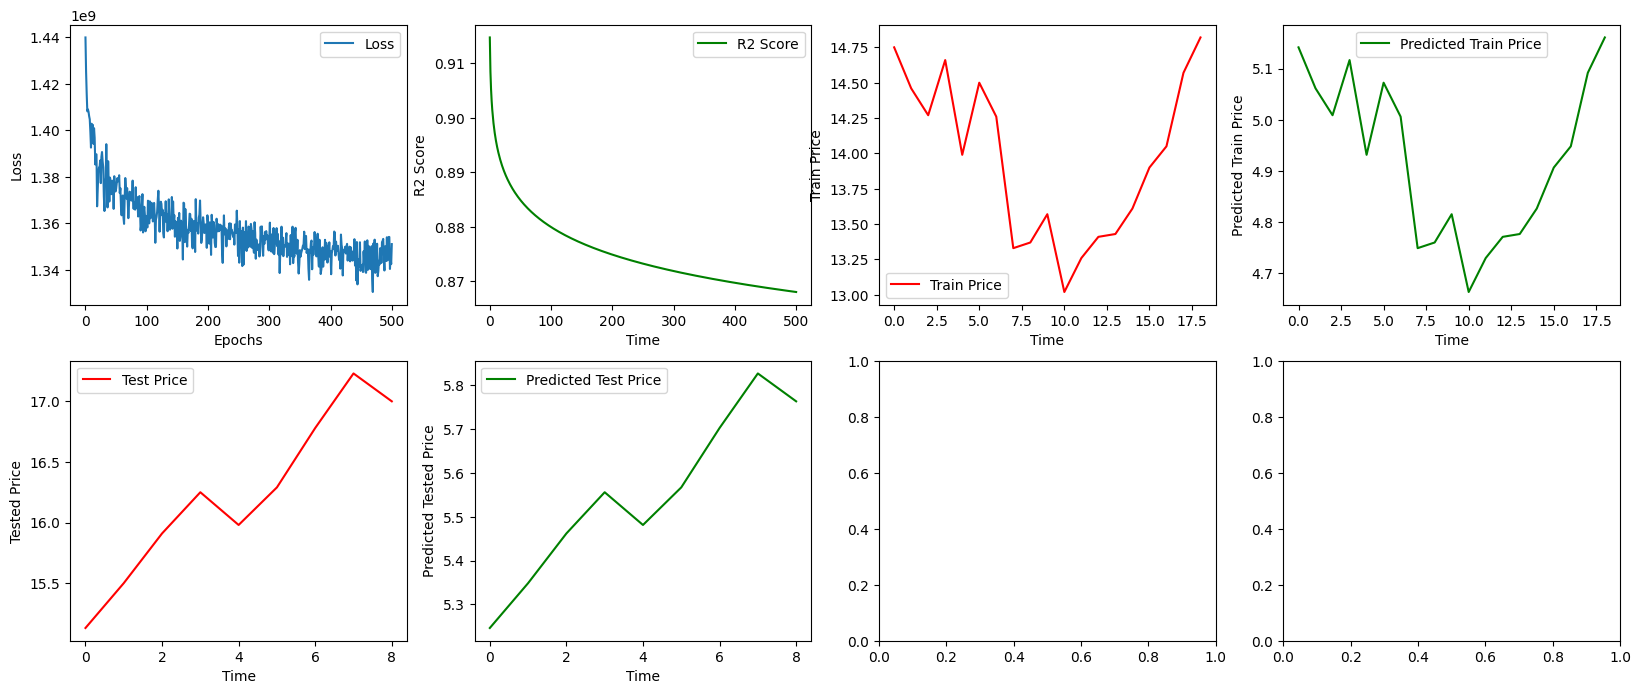

In [160]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax[0, 0].plot([e for e in range(len(model.loss_history))], model.loss_history, label="Loss")
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].legend()

ax[0, 2].plot([e for e in range(len(model.X_train))], model.X_train[:, -1], label="Train Price", color='red')
ax[0, 2].set_ylabel('Train Price')
ax[0, 2].set_xlabel('Time')
ax[0, 2].legend()

ax[0, 3].plot([e for e in range(len(model.X_train))], model.predicted_train[:, -1], label="Predicted Train Price", color='green')
ax[0, 3].set_ylabel('Predicted Train Price')
ax[0, 3].set_xlabel('Time')
ax[0, 3].legend()

ax[1, 0].plot([e for e in range(len(model.X_test))], model.X_test[:, -1], label="Test Price", color='red')
ax[1, 0].set_ylabel('Tested Price')
ax[1, 0].set_xlabel('Time')
ax[1, 0].legend()

ax[1, 1].plot([e for e in range(len(model.X_test))], model.predicted_test[:, -1], label="Predicted Test Price", color='green')
ax[1, 1].set_ylabel('Predicted Tested Price')
ax[1, 1].set_xlabel('Time')
ax[1, 1].legend()

ax[0, 1].plot([e for e in range(len(model.r2_history))], model.r2_history, label="R2 Score", color='green')
ax[0, 1].set_ylabel('R2 Score')
ax[0, 1].set_xlabel('Time')
ax[0, 1].legend()